Importamos las librerias necesarias para el EDA

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

Carga de los datos

In [3]:
df_movies= pd.read_csv("proyecto1.csv", sep= ',')

Primera visualizacion de datos con metodos como: head(), info(), describe()

In [ ]:
df_movies.head()

In [ ]:
df_movies.info()

In [ ]:
df_movies.describe()

Busqueda de nulos 

In [ ]:
print(df_movies.isnull().sum())  

Presentacion de histogramas para algunas variables numericas claves.

In [ ]:
#"vote_average" 
df_movies['vote_average'].hist(bins=30) 

<Axes: >

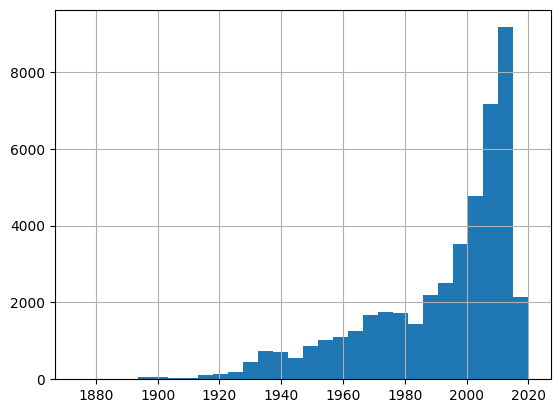

In [366]:
#"release_year" 
df_movies['release_year'].hist(bins=30) 

Presentacion de un mapa de calor asociado a la matriz de correlacion.

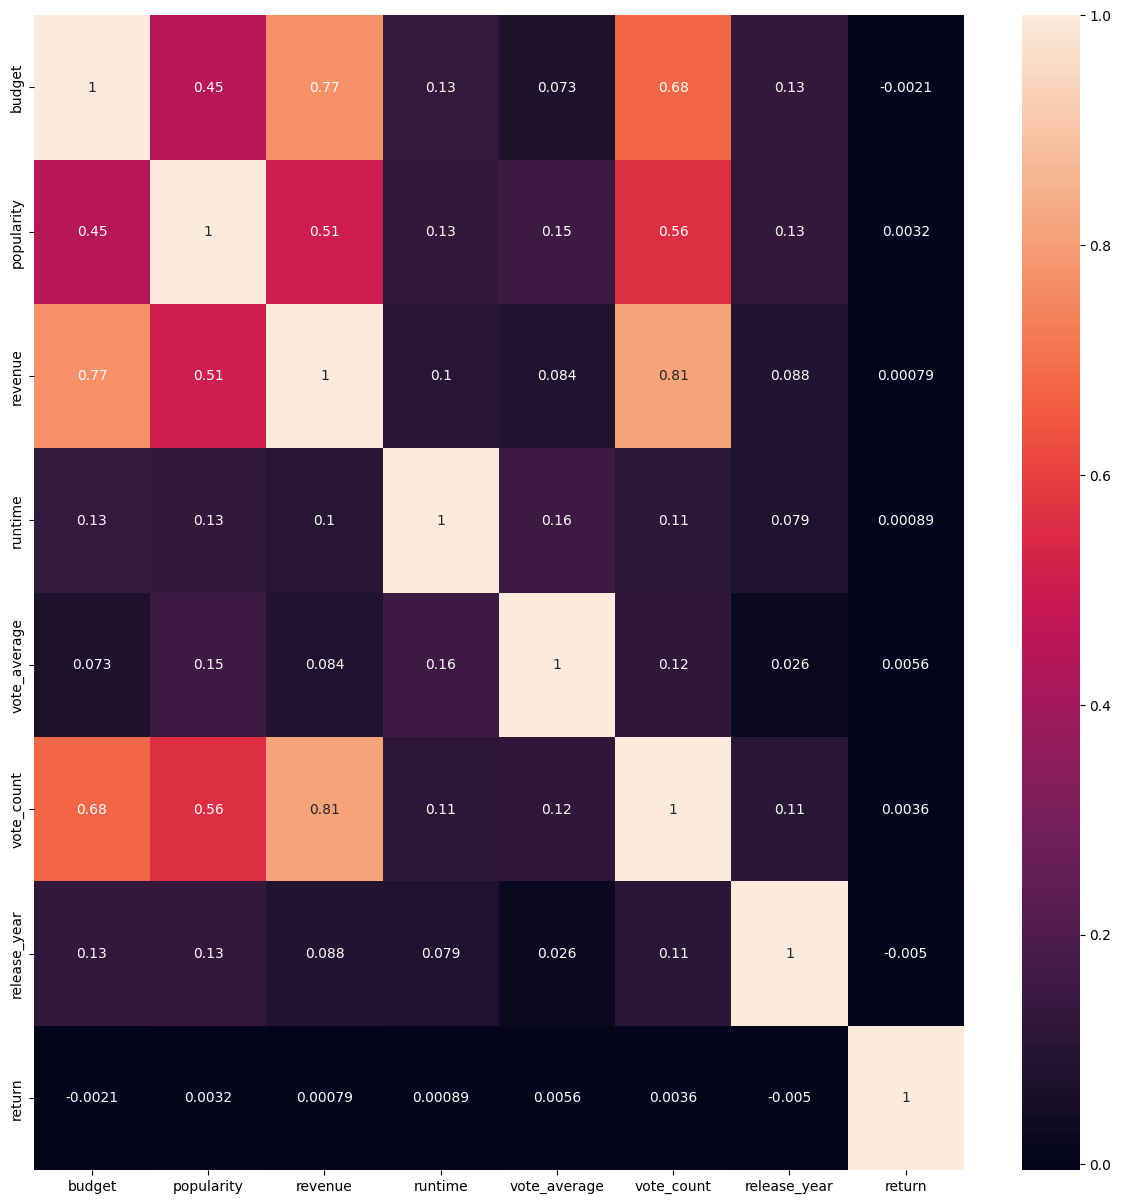

In [368]:
#Variables numericas importantes
df = df_movies[['budget','popularity','revenue', 'runtime',
                'vote_average', 'vote_count', 'release_year', 'return']]
#Calculo de matriz de correlacion
corr_matrix = df.corr() 
plt.figure(figsize=(15,15))
#Diseño de mapa de calor
sns.heatmap(corr_matrix, annot=True) 
plt.show()

Creacion de una nube de palabras con la categoria "name_genre"

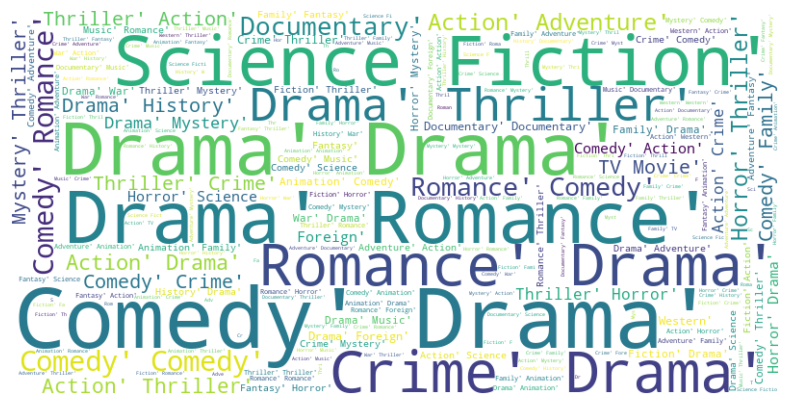

In [371]:
#Crear variable a mostrar, borrando nulos y convirtiendo a string.
data = df_movies['name_genre'].dropna().to_string()

#Crear nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)  
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  
plt.axis("off")
plt.show()

Creacion de una nube de palabras con la categoria "Title"

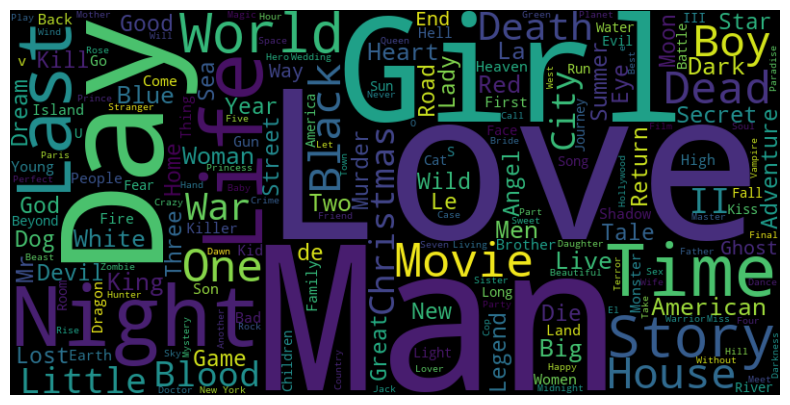

In [372]:
#Crear variable a mostrar, borrando nulos y convirtiendo a string.
data = df_movies['title'].dropna().to_string()

#Crear nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(data)  
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')  
plt.axis("off")
plt.show()

Creacion de un nuevo dataframe con las variables necesarias para el sistema de recomendacion

In [373]:
df_modelo= df_movies[['overview', 'title', 'popularity', 'name_genre']]

Preprocesamiento de texto para el modelo de ML

In [374]:
import itertools
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer
import string


Completar los nulos con un espacio vacio. La columna a trabajar es "overview"

In [ ]:
df_modelo['overview'] = df_modelo['overview'].fillna('')

In [376]:
data= df_modelo['overview']

En primer lugar creamos los tokens

In [377]:
token= []

for i in data:
    token.append(word_tokenize(i))

In [378]:
len(token)

45390

En segundo lugar, eliminamos los signos de puntuacion

In [380]:
token2= []

for element in token:
    words= []
    for word in element:
        for letter in word:
            if letter in string.punctuation:
                word=word.replace(letter, "")
        
        words.append(word)
    token2.append(words)
    

In [381]:
len(token2)

45390

En tercer lugar, eliminamos los espacios vacios

In [383]:
token3 = []

for element in token2:
    words= []
    for word in element:
        if word != "":
            words.append(word)

    token3.append(words)

In [384]:
len(token3)

45390

En cuarto lugar, cambiamos todas las palabras a minusculas

In [386]:
token4= []

for element in token3:
    words= []
    
    for word in element:
        word= word.lower()
        words.append(word)
    
    token4.append(words)


In [387]:
len(token4)

45390

En quinto lugar, eliminamos las palabras con menos de 3 letras por ser innecesarias

In [389]:
token5= []

for element in token4:
    words= []
    for word in element:
        if len(word)>=3:
            words.append(word)
    token5.append(words)


In [390]:
len(token5)

45390

En sexto lugar, eliminamos los stopwords

In [392]:
a= set(stopwords.words('english'))

token6= []

for element in token5:
    words= []
    for word in element:
        if word not in a:
            words.append(word)
    token6.append(words)

In [393]:
len(token6)

45390

Por ultimo, se calculan las palabras mas frecuentes y se agregan a una lista, para luego agregarlas al dataframe como una nueva columna

In [395]:
key_words= []

for element in token6:
    lista= []
    fdist= FreqDist(element)

    for i in fdist.most_common(10):
        lista.append(i[0])
    
    key_words.append(lista)

In [ ]:
df_modelo['keywords']= key_words

Se hacen transformaciones a la nueva columna: stemming, reemplazar caracteres, cambiar el tipo de dato a str.

In [398]:
stemmer = SnowballStemmer('english')

In [ ]:
df_modelo['keywords'] = df_modelo['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
df_modelo['keywords'] = df_modelo['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
df_modelo['keywords'] = df_modelo['keywords'].apply(lambda x: ''.join(str(x)))

Se concatenan en una nueva columna la informacion obtenida de keywords y los generes de las peliculas

In [ ]:
df_modelo['info'] = df_modelo['keywords'] + df_modelo['name_genre']

Por una cuestion de memoria y capacidad, decidi realizar el modelo de machine learning sobre una muestra de los datos de 5000 registros. Como indicador para la eleccion de las filas tome como filtro la popularidad de las peliculas.

In [ ]:
df_modelo.sort_values(by=['popularity'], inplace=True, ascending=False, ignore_index= True)

In [402]:
df_muestra= df_modelo[['title', 'info']].loc[:5000]

Se eliminan registros duplicados

In [428]:
df_muestra.drop_duplicates(subset=['title'], inplace=True)

El dataframe 'df_muestra' es el que va a ser utilizado para la creacion del modelo de ML.

In [430]:
df_muestra.to_csv('modelo.csv', index=False)

In [451]:
df_total= pd.read_csv('proyecto1.csv')

In [462]:
df_total.columns

Index(['budget', 'id', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'name_collection', 'name_genre',
       'name_language', 'name_production_companies', 'name_country',
       'release_year', 'return', 'actors_names', 'directors_names'],
      dtype='object')

In [ ]:
df_total['directors_names'][42827] = '[]'
df_total['actors_names'][42827] = '[]'

In [469]:
get_actor('Leonardo Di Caprio')

C:\Users\Dell\AppData\Local\Temp\ipykernel_15368\4099870331.py:6: RuntimeWarning: invalid value encountered in double_scalars
  promedio= retorno_total / cantidad


{'actor': 'Leonardo Di Caprio',
 'cantidad_filmaciones': '0',
 'retorno_total': '0.0',
 'retorno_promedio': 'nan'}